In [9]:
# 将 Google Drive 挂载到 Colab 虚拟机，使其像本地文件夹一样可用
from google.colab import drive
drive.mount('/content/drive')

# TODO：请填写你在 Google Drive 中存放解压后作业文件夹的路径
# 示例：'cs231n/assignments/assignment1/'
# 请根据你的实际路径进行修改
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] 请填写正确的文件夹路径。"

# 挂载完成后，把该路径加入 Python 的模块搜索路径，
# 确保 Colab 虚拟机的解释器能找到并加载其中的 .py 文件
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# 如果 CIFAR-10 数据集尚未存在，则将其下载到 Google Drive
# 进入数据集目录
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# 执行下载脚本，自动下载并解压 CIFAR-10
!bash get_datasets.sh
# 下载完成后返回作业根目录
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google'

# k 近邻（kNN）练习

*请将这份完整的练习表（包括所有输出结果以及表格外部的支持代码）随本次作业一并提交。更多详情见课程官网的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

kNN 分类器包含两个阶段：

- **训练阶段**：分类器仅读取并“记忆”所有训练数据，不做额外计算。  
- **测试阶段**：对每张测试图像，kNN 将其与所有训练图像逐一比较，找出最相似的 k 张训练图像，并将这 k 张图像中出现次数最多的标签赋给测试图像。  
- **k 值的选择**通过交叉验证确定。

在本练习中，你将实现上述步骤，借此掌握图像分类的基本流程，理解交叉验证，并提高编写高效、向量化代码的能力。

In [1]:
# 运行本 notebook 所需的初始化代码

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10   # 加载 CIFAR-10 数据的工具函数
import matplotlib.pyplot as plt

# 让 matplotlib 图形直接嵌入在 notebook 中，而不是弹出新窗口
%matplotlib inline
# 统一设置图片默认大小，便于查看
plt.rcParams['figure.figsize'] = (10.0, 8.0)
# 关闭插值，使像素边界更清晰
plt.rcParams['image.interpolation'] = 'nearest'
# 灰度图默认使用灰度色图
plt.rcParams['image.cmap'] = 'gray'

# 开启 IPython 的自动重载功能：修改外部 .py 文件后无需重启 kernel 即可生效
# 官方讨论贴地址：http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 注意：由于网络原因，上述链接暂时无法成功解析。如果你需要查看该网页内容，
# 请检查链接是否有效，或稍后重试；若不需要查看，可直接继续后续操作。
%load_ext autoreload
%autoreload 2

In [2]:
# 加载原始 CIFAR-10 数据
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 如果之前已加载过数据，先删除相关变量，防止重复加载导致内存占用过高
try:
    del X_train, y_train
    del X_test, y_test
    print('已清空之前加载的数据。')
except:
    pass

# 真正从磁盘读取 CIFAR-10
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 简单检查：打印训练集和测试集的形状
print('训练数据形状: ', X_train.shape)
print('训练标签形状: ', y_train.shape)
print('测试数据形状: ', X_test.shape)
print('测试标签形状: ', y_test.shape)

训练数据形状:  (50000, 32, 32, 3)
训练标签形状:  (50000,)
测试数据形状:  (10000, 32, 32, 3)
测试标签形状:  (10000,)


d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27773 (\N{CJK UNIFIED IDEOGRAPH-6C7D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40479 (\N{CJK UNIFIED IDEOGRAPH-9E1F}) missing from font(s) DejaVu Sans.
  

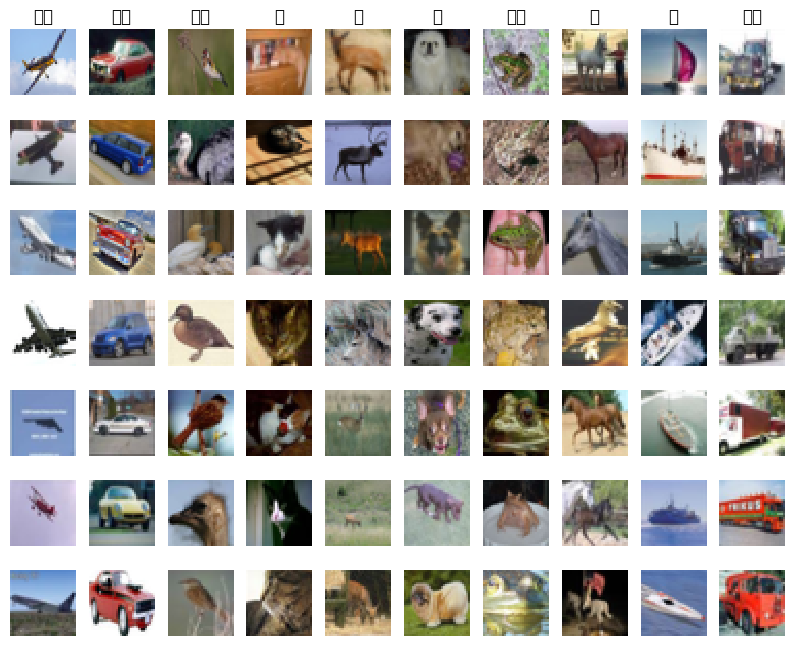

In [3]:
# 可视化数据集中的一些样本
# 从每个类别中随机展示若干张训练图像

classes = ['飞机', '汽车', '鸟类', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
num_classes = len(classes)              # 类别数（10）
samples_per_class = 7                   # 每类展示 7 张图

for y, cls in enumerate(classes):
    # 找到所有属于当前类别的训练样本索引
    idxs = np.flatnonzero(y_train == y)
    # 随机选择 7 张且不重复
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        # 计算子图位置
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # 显示图像
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        # 只在第一行写类别名
        if i == 0:
            plt.title(cls)

plt.show()

In [4]:
# 为了在本练习中更高效地运行代码，对数据进行子采样
num_training = 5000          # 仅保留前 5000 张训练图像
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500               # 仅保留前 500 张测试图像
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 将图像数据展平成行向量（每行代表一张图像的所有像素）
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test  = np.reshape(X_test,  (X_test.shape[0],  -1))

# 打印处理后的数据形状
print('训练数据形状:', X_train.shape)
print('测试数据形状:', X_test.shape)

训练数据形状: (5000, 3072)
测试数据形状: (500, 3072)


In [5]:
# 从 cs231n.classifiers 中导入 k 近邻分类器
from cs231n.classifiers import KNearestNeighbor

# 创建 kNN 分类器实例
# 注意：训练 kNN 分类器实际上什么都不做（no-op）：
# 分类器只是把训练数据“记住”，不会进行任何额外处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)  # 仅保存训练数据

现在我们希望用 kNN 分类器对测试数据进行分类。  
整个过程可以拆成两步：

1. **计算所有测试样本与所有训练样本之间的距离**  
   如果有 **Ntr** 个训练样本和 **Nte** 个测试样本，这一步应得到一个 **Nte × Ntr** 的距离矩阵，其中元素 (i, j) 表示第 i 个测试样本与第 j 个训练样本之间的距离。

2. **根据距离矩阵，对每个测试样本找出最近的 k 个训练样本，并通过投票决定其标签**

首先从计算距离矩阵开始。  
**注意：本 notebook 中要求你实现的三种距离计算方法均不得使用 Numpy 提供的 `np.linalg.norm()`。**

请先打开 `cs231n/classifiers/k_nearest_neighbor.py`，在 `compute_distances_two_loops` 函数中用**双重显式循环**（非常低效）逐个计算所有 (测试, 训练) 样本对的距离。

In [7]:
# 打开文件 cs231n/classifiers/k_nearest_neighbor.py
# 在文件中实现 compute_distances_two_loops 函数

# 测试你的实现：
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)  # 应输出 (500, 5000)，即 500 个测试样本与 5000 个训练样本的距离矩阵

(500, 5000)


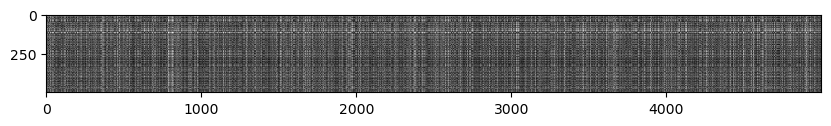

In [8]:
# 可视化距离矩阵：矩阵的每一行对应一个测试样本
# 行中的每个像素值表示该测试样本与所有训练样本之间的距离
plt.imshow(dists, interpolation='none')
plt.show()

**内联问题 1**

在距离矩阵中可以观察到明显的结构性模式：某些行或列看起来明显更亮。（默认配色下，黑色表示距离小，白色表示距离大。）

- 造成这些**明显更亮的行**的原因是什么？
- 造成这些**明显更亮的列**的原因是什么？

$\color{blue}{\textit 你的答案：}$ *请在此处填写。*



In [ ]:
###行：这个测试样本和所有的训练样本都不像，测试样本有问题
###列：这个训练样本和所有的测试样本都不像，训练样本有问题

In [9]:
# 现在实现 predict_labels 函数，并运行下方代码
# 这里取 k = 1，即最近邻（Nearest Neighbor）
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并打印预测正确的比例
num_correct = np.sum(y_test_pred == y_test)  # 正确预测的样本数
accuracy = float(num_correct) / num_test     # 准确率
print('预测正确 %d / %d 个样本 => 准确率: %f' % (num_correct, num_test, accuracy))

预测正确 137 / 500 个样本 => 准确率: 0.274000


你应该会看到大约 `27%` 的准确率。  
现在我们尝试更大的 `k`，设 `k = 5`：

In [10]:
# 使用 k=5 重新预测
y_test_pred = classifier.predict_labels(dists, k=5)

# 计算正确预测数量
num_correct = np.sum(y_test_pred == y_test)

# 计算准确率
accuracy = float(num_correct) / num_test
print('预测正确 %d / %d 个样本 => 准确率: %f' % (num_correct, num_test, accuracy))

预测正确 139 / 500 个样本 => 准确率: 0.278000


你应该会看到准确率比 `k = 1` 时略有提升。

**内联问题 2**

我们也可以使用其他距离度量，例如 L1 距离。  
记图像 $I_k$ 在位置 $(i,j)$ 处的像素值为 $p_{ij}^{(k)}$，

所有像素在所有图像上的全局均值为  
$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$  

每个像素在所有图像上的像素级均值为  
$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}$  

类似地可定义全局标准差 $\sigma$ 和像素级标准差 $\sigma_{ij}$。

对于使用 L1 距离的最近邻分类器，下列哪些预处理步骤**不会改变其性能**？（可多选）  
注意：训练集和测试集均采用完全相同的预处理方式。

1. 减去全局均值 $\mu$（$\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$）。
2. 减去像素级均值 $\mu_{ij}$（$\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$）。
3. 先减去全局均值 $\mu$，再除以全局标准差 $\sigma$。
4. 先减去像素级均值 $\mu_{ij}$，再除以像素级标准差 $\sigma_{ij}$。
5. 将数据的坐标轴整体旋转，即把所有图像按同一角度旋转。旋转造成的图像空白区域用同一像素值填充，且不做插值。

$\color{blue}{\textit{你的答案：}}$

$\color{blue}{\textit{你的解释：}}$


In [11]:
# 现在用“部分向量化 + 单循环”来加速距离矩阵的计算。
# 请在 k_nearest_neighbor.py 中实现 compute_distances_one_loop 函数，然后运行下方代码：
dists_one = classifier.compute_distances_one_loop(X_test)

# 为确保向量化实现正确，我们将其与朴素实现进行比较。
# 判断两个矩阵是否一致的最简单方法之一是 Frobenius 范数。
# Frobenius 范数：把两个矩阵拉平成向量后，计算它们的欧氏距离
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('单循环实现与朴素实现的差异: %f' % difference)
if difference < 0.001:
    print('很好！两个距离矩阵完全一致。')
else:
    print('警告！两个距离矩阵不相同。')

单循环实现与朴素实现的差异: 0.000000
很好！两个距离矩阵完全一致。


In [13]:
# 现在请在 compute_distances_no_loops 中实现完全向量化的版本，
# 并运行以下代码：
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查新的距离矩阵与之前计算的是否一致：
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('无循环差异：%.6f' % difference)
if difference < 0.001:
    print('很好！两个距离矩阵完全一致。')
else:
    print('警告！两个距离矩阵不相同。')

无循环差异：0.000000
很好！两个距离矩阵完全一致。


In [14]:
# 比较不同实现的运行速度
def time_function(f, *args):
    """
    调用函数 f 并传入参数 args，返回函数执行所需的时间（秒）。
    """
    import time
    tic = time.time()  # 记录开始时间
    f(*args)           # 执行函数
    toc = time.time()  # 记录结束时间
    return toc - tic   # 返回执行时间

# 测试三种实现的运行时间
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('双重循环版本耗时 %f 秒' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('单循环版本耗时 %f 秒' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('无循环（完全向量化）版本耗时 %f 秒' % no_loop_time)

# 你应该会看到完全向量化实现的性能显著提升！

# 注意：根据你使用的机器配置，
# 从双重循环到单循环，你可能看不到速度提升，
# 甚至可能会变慢。

双重循环版本耗时 14.216250 秒
单循环版本耗时 32.749733 秒
无循环（完全向量化）版本耗时 0.100423 秒


### 交叉验证

我们已经实现了 k 近邻分类器，但之前将 k 值随意设为 5。  
接下来，我们将通过**交叉验证**来确定这个超参数的最佳值。

In [15]:

num_folds = 5# 设置交叉验证的折数
# 设置 k 值的候选列表
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# 用于存储每折的训练数据和标签
X_train_folds = []
y_train_folds = []
################################################################################
# 代办:                                                                         #
# 将训练数据分成 num_folds 份。完成后，X_train_folds 和 y_train_folds 应该是长度为#
# num_folds 的列表，其中 y_train_folds[i] 是 X_train_folds[i] 的标签向量。       #
# 提示：查看 numpy 的 array_split 函数。                                        #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# 用于存储不同 k 值对应的准确率
# 交叉验证完成后，k_to_accuracies[k] 应该是一个长度为 num_folds 的列表，包含使用该 k 值时的准确率
k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k]=[]
    for i in range(num_folds):
        X_val_folds=X_train_folds[i]
        y_val_folds=y_train_folds[i]
        X_train_folds_com=np.concatenate(X_train_folds[:i]+X_train_folds[i+1:],axis=0)
        y_train_folds_com=np.concatenate(y_train_folds[:i]+y_train_folds[i+1:],axis=0)
        classifier.train(X_train_folds_com,y_train_folds_com)
        y_val_pred = classifier.predict(X_val_folds, k=k)
        accuracy = np.mean(y_val_pred == y_val_folds)
        k_to_accuracies[k].append(accuracy)

##########################################################################################
# 代办:                                                                                  #
# 执行 k 折交叉验证，找到最佳的 k 值。对于每个可能的 k 值，运行 k 近邻算法 num_folds 次，    #
# 每次使用除一折外的所有数据作为训练集，剩下的一折作为验证集。将所有折和所有 k 值的准确率存储在#
# k_to_accuracies 字典中。                                                                #
##########################################################################################



# 打印计算出的准确率
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, 准确率 = %f' % (k, accuracy))

k = 1, 准确率 = 0.263000
k = 1, 准确率 = 0.257000
k = 1, 准确率 = 0.264000
k = 1, 准确率 = 0.278000
k = 1, 准确率 = 0.266000
k = 3, 准确率 = 0.239000
k = 3, 准确率 = 0.249000
k = 3, 准确率 = 0.240000
k = 3, 准确率 = 0.266000
k = 3, 准确率 = 0.254000
k = 5, 准确率 = 0.248000
k = 5, 准确率 = 0.266000
k = 5, 准确率 = 0.280000
k = 5, 准确率 = 0.292000
k = 5, 准确率 = 0.280000
k = 8, 准确率 = 0.262000
k = 8, 准确率 = 0.282000
k = 8, 准确率 = 0.273000
k = 8, 准确率 = 0.290000
k = 8, 准确率 = 0.273000
k = 10, 准确率 = 0.265000
k = 10, 准确率 = 0.296000
k = 10, 准确率 = 0.276000
k = 10, 准确率 = 0.284000
k = 10, 准确率 = 0.280000
k = 12, 准确率 = 0.260000
k = 12, 准确率 = 0.295000
k = 12, 准确率 = 0.279000
k = 12, 准确率 = 0.283000
k = 12, 准确率 = 0.280000
k = 15, 准确率 = 0.252000
k = 15, 准确率 = 0.289000
k = 15, 准确率 = 0.278000
k = 15, 准确率 = 0.282000
k = 15, 准确率 = 0.274000
k = 20, 准确率 = 0.270000
k = 20, 准确率 = 0.279000
k = 20, 准确率 = 0.279000
k = 20, 准确率 = 0.282000
k = 20, 准确率 = 0.285000
k = 50, 准确率 = 0.271000
k = 50, 准确率 = 0.288000
k = 50, 准确率 = 0.278000
k = 50, 准确率 = 0.269000
k = 50, 

d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  

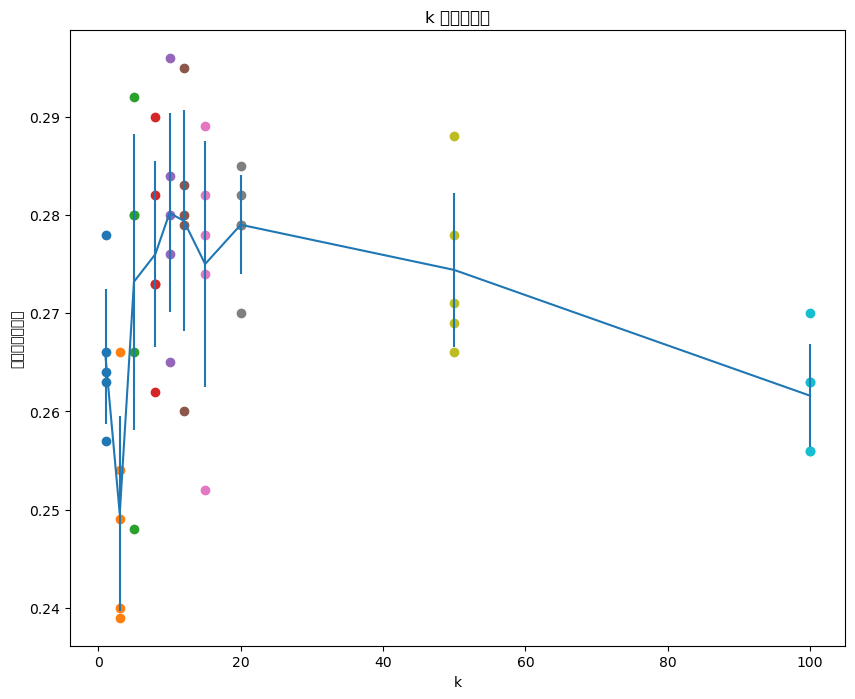

In [16]:
# 绘制原始观测结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 绘制趋势线，并用误差条表示标准差
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('k 的交叉验证')
plt.xlabel('k')
plt.ylabel('交叉验证准确率')
plt.show()

In [17]:
# 根据上述交叉验证结果，选择最佳的 k 值，
# 使用全部训练数据重新训练分类器，并在测试数据上进行测试。
# 你应该能够在测试数据上获得超过 28% 的准确率。
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并显示准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('预测正确 %d / %d => 准确率: %f' % (num_correct, num_test, accuracy))

预测正确 137 / 500 => 准确率: 0.274000


**内联问题 3**

在分类设置中，以下关于 k 近邻（k-NN）的陈述哪些是正确的，且对所有 k 都成立？请选择所有适用的选项。
1. k-NN 分类器的决策边界是线性的。
2. 1-NN 的训练误差总是低于或等于 5-NN 的训练误差。
3. 1-NN 的测试误差总是低于 5-NN 的测试误差。
4. 使用 k-NN 分类器对测试样本进行分类所需的时间随着训练集的大小而增加。
5. 以上都不是。

$\color{blue}{\textit{你的答案：}}$


$\color{blue}{\textit{你的解释：}}$

